### User Input

In [1]:

mfccs_json_path = "../mfccs_cnn_humpbackwhale_walrus_killerwhale_bowheadwhale_fin_finbackwhale_emptyocean.json"

accuracy_loss_image = "/Users/sydne/Documents/marine-mammal-call-classification/acc_loss_metrics_2.png"

confusion_mat_image = "/Users/sydne/Documents/marine-mammal-call-classification/finalCFcnn.png"

### Imports

In [28]:
import tensorflow as tf
import tensorflow.keras as keras
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd 
import numpy as np
import warnings

import glob
import os

from cnn_comparison_lib import save_single_mfcc_for_demo

ImportError: cannot import name 'save_single_mfcc_for_demo' from 'cnn_comparison_lib' (c:\Users\sydne\OneDrive - Queen's University\Capstone\marine-mammal-call-classification\step5-model-comparisons\cnn_comparison_lib.py)

### Load MFCC Dataset

In [3]:
from cnn_comparison_lib import load_cnn_json

X, y, L = load_cnn_json(mfccs_json_path)
print(f"mapping the marine mammals: {L}")
# Check class counts and that labels are numerical order
np.unique(y, return_counts=True)

mapping the marine mammals: ['BowheadWhale' 'EmptyOcean' 'Fin_FinbackWhale' 'HumpbackWhale'
 'KillerWhale' 'Walrus']


(array([1, 2, 3, 4, 5, 6]),
 array([1000, 1000, 1000, 1000, 1000, 1000], dtype=int64))

### Create Training, Validation, and Test Sets

In [4]:
# create train, validation and test sets
from cnn_comparison_lib import prepare_datasets

X_train, X_validation, X_test, y_train, y_validation, y_test = prepare_datasets(X, y, 0.8, 0.3) # test size, vailidation size
input_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3])

### Build the 3-Layer Models

In [5]:
from cnn_comparison_lib import create_layered_cnn

L3_model_list = []
for i in range(10):
    output_shape = i*100 + 32
    model = create_layered_cnn(3, input_shape, output_shape)
    L3_model_list.append(model)

### Get 3-Layer Trainable Parameter Count

In [6]:
from cnn_comparison_lib import count_trainable_parameters

L3_parameter_count = []
for model in L3_model_list:
    count = count_trainable_parameters(model)
    L3_parameter_count.append(count)

print(L3_parameter_count)

[261321, 1313521, 2725721, 4497921, 6630121, 9122321, 11974521, 15186721, 18758921, 22691121]


### Train the 3-Layer Models

In [7]:
from cnn_comparison_lib import plot_history

L3_history = []
for model in L3_model_list:
    history = model.fit(X_train, y_train, validation_data=(X_validation, y_validation), batch_size=16, epochs=5)
    L3_history.append(history)

Epoch 1/5
53/53 [==============================] - 4s 54ms/step - loss: 1.0879 - accuracy: 0.6667 - val_loss: 1.6399 - val_accuracy: 0.3417
Epoch 2/5
53/53 [==============================] - 3s 48ms/step - loss: 0.4187 - accuracy: 0.8833 - val_loss: 0.9744 - val_accuracy: 0.7694
Epoch 3/5
53/53 [==============================] - 3s 49ms/step - loss: 0.2314 - accuracy: 0.9202 - val_loss: 0.4781 - val_accuracy: 0.8583
Epoch 4/5
53/53 [==============================] - 3s 49ms/step - loss: 0.1642 - accuracy: 0.9548 - val_loss: 0.2082 - val_accuracy: 0.9306
Epoch 5/5
53/53 [==============================] - 3s 49ms/step - loss: 0.1298 - accuracy: 0.9583 - val_loss: 0.1350 - val_accuracy: 0.9611
Epoch 1/5
53/53 [==============================] - 11s 186ms/step - loss: 0.5545 - accuracy: 0.8214 - val_loss: 5.0275 - val_accuracy: 0.2750
Epoch 2/5
53/53 [==============================] - 10s 182ms/step - loss: 0.1376 - accuracy: 0.9536 - val_loss: 1.3611 - val_accuracy: 0.5111
Epoch 3/5
53/53 

### Evaluate the 3-Layer Models

In [8]:
# evaluate the cnn on the test set
L3_accuracy = []
for model in L3_model_list:
    test_error, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
    L3_accuracy.append(test_accuracy)

150/150 [==============================] - 168s 1s/step - loss: 1.2529 - accuracy: 0.7973


### Plot the 3-Layer Models

Text(0, 0.5, 'Model Accuracy')

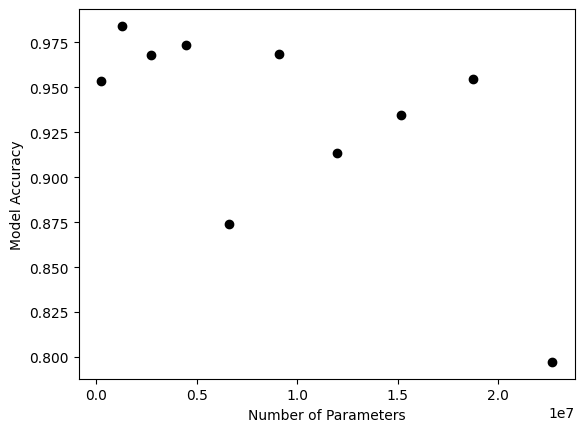

In [9]:
x = L3_parameter_count
y = L3_accuracy
plt.plot(x, y, 'o', color='black')
plt.xlabel("Number of Parameters")
plt.ylabel("Model Accuracy")

### Save the models

In [10]:
count = 1
for model in L3_model_list:
    model.save("syd_saved_models/empty_ocean/cnn_model_6_classes_dropout_01_"+str(count))
    count = count + 1

INFO:tensorflow:Assets written to: syd_saved_models/empty_ocean/cnn_model_6_classes_dropout_01_1\assets


INFO:tensorflow:Assets written to: syd_saved_models/empty_ocean/cnn_model_6_classes_dropout_01_1\assets


INFO:tensorflow:Assets written to: syd_saved_models/empty_ocean/cnn_model_6_classes_dropout_01_2\assets


INFO:tensorflow:Assets written to: syd_saved_models/empty_ocean/cnn_model_6_classes_dropout_01_2\assets


INFO:tensorflow:Assets written to: syd_saved_models/empty_ocean/cnn_model_6_classes_dropout_01_3\assets


INFO:tensorflow:Assets written to: syd_saved_models/empty_ocean/cnn_model_6_classes_dropout_01_3\assets


INFO:tensorflow:Assets written to: syd_saved_models/empty_ocean/cnn_model_6_classes_dropout_01_4\assets


INFO:tensorflow:Assets written to: syd_saved_models/empty_ocean/cnn_model_6_classes_dropout_01_4\assets


INFO:tensorflow:Assets written to: syd_saved_models/empty_ocean/cnn_model_6_classes_dropout_01_5\assets


INFO:tensorflow:Assets written to: syd_saved_models/empty_ocean/cnn_model_6_classes_dropout_01_5\assets


INFO:tensorflow:Assets written to: syd_saved_models/empty_ocean/cnn_model_6_classes_dropout_01_6\assets


INFO:tensorflow:Assets written to: syd_saved_models/empty_ocean/cnn_model_6_classes_dropout_01_6\assets


INFO:tensorflow:Assets written to: syd_saved_models/empty_ocean/cnn_model_6_classes_dropout_01_7\assets


INFO:tensorflow:Assets written to: syd_saved_models/empty_ocean/cnn_model_6_classes_dropout_01_7\assets


INFO:tensorflow:Assets written to: syd_saved_models/empty_ocean/cnn_model_6_classes_dropout_01_8\assets


INFO:tensorflow:Assets written to: syd_saved_models/empty_ocean/cnn_model_6_classes_dropout_01_8\assets


INFO:tensorflow:Assets written to: syd_saved_models/empty_ocean/cnn_model_6_classes_dropout_01_9\assets


INFO:tensorflow:Assets written to: syd_saved_models/empty_ocean/cnn_model_6_classes_dropout_01_9\assets


INFO:tensorflow:Assets written to: syd_saved_models/empty_ocean/cnn_model_6_classes_dropout_01_10\assets


INFO:tensorflow:Assets written to: syd_saved_models/empty_ocean/cnn_model_6_classes_dropout_01_10\assets


In [36]:
# trying to test getting the model to predict something (can delete this cell after, it's not needed for the GUI)
# This logic is meant for predict() function for gradio

for model in L3_model_list:
    model_1 = model
    break

audio_path="../data_augmented_demo/"
json_path_with_mfcc = save_single_mfcc_for_demo(audio_path)
X, y, L = load_cnn_json(json_path_with_mfcc)
test_error, test_accuracy = model.evaluate(X, y, verbose=1)

NameError: name 'save_single_mfcc_for_demo' is not defined

In [1]:
import gradio as gr

def predict(audio):
    return "Demo"

demo = gr.Interface(fn=predict, inputs=gr.Audio(value="../data_augmented_demo/KillerWhale_aug_0.wav"), outputs="text")

demo.launch(share=True) 

Running on local URL:  http://127.0.0.1:7860

Could not create share link, please check your internet connection.
